
# Galaxies vs quasars with neural networks

Let's go back to our galaxy vs quasar data we've used in a previous exercise.

- Read in SDSS galaxy color data from solutions/galaxyquasar.csv. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$.

- Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

- Now train the classifier. Use a package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning.

- Start from a network architecture with a single hidden layer with 5 neurons, using the adam solver, the relu activation function, and a learning rate of $0.001$. Plot the resulting ROC curve.

- Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best. Do your best now to optimize the network architecture. Be creative!

- Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?

A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with n_jobs=-1. Print out the classification score for the training data, and the best parameters obtained by the cross validation.

- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.

- On cross validation, for scikit learn we've seen how to use GridSearchCV already. For Tensorflow, there's a really cool tool called Tensorboard.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import os
import keras
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

#------------------------------------------------------------------------------------

def table_results(y, y_pred): 

    accuracy = accuracy_score(y, y_pred)
    contamination = 1 - precision_score(y, y_pred)
    completeness = recall_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    return accuracy, contamination, completeness, tn, fp, fn, tp


In [3]:
data = pd.read_csv('galaxyquasar.csv')
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [4]:
usecols = ['u', 'g', 'r', 'i', 'z', 'class', 'z1', 'zerr']

u_g = np.array(data.get(usecols[0]) - data.get(usecols[1]))
g_r = np.array(data.get(usecols[1]) - data.get(usecols[2]))
r_i = np.array(data.get(usecols[2]) - data.get(usecols[3]))
i_z = np.array(data.get(usecols[3]) - data.get(usecols[4]))

target = np.array(data.get(usecols[5]))

X=np.array([u_g, g_r, r_i, i_z]).T
y = np.empty(shape = u_g.size)     # Class labels

for i, label in enumerate(target):
    if (label == 'GALAXY'): y[i] = 0
    elif (label == 'QSO'): y[i] = 1

Let's first display the plots from the L19 exercise, to get an idea of the data:

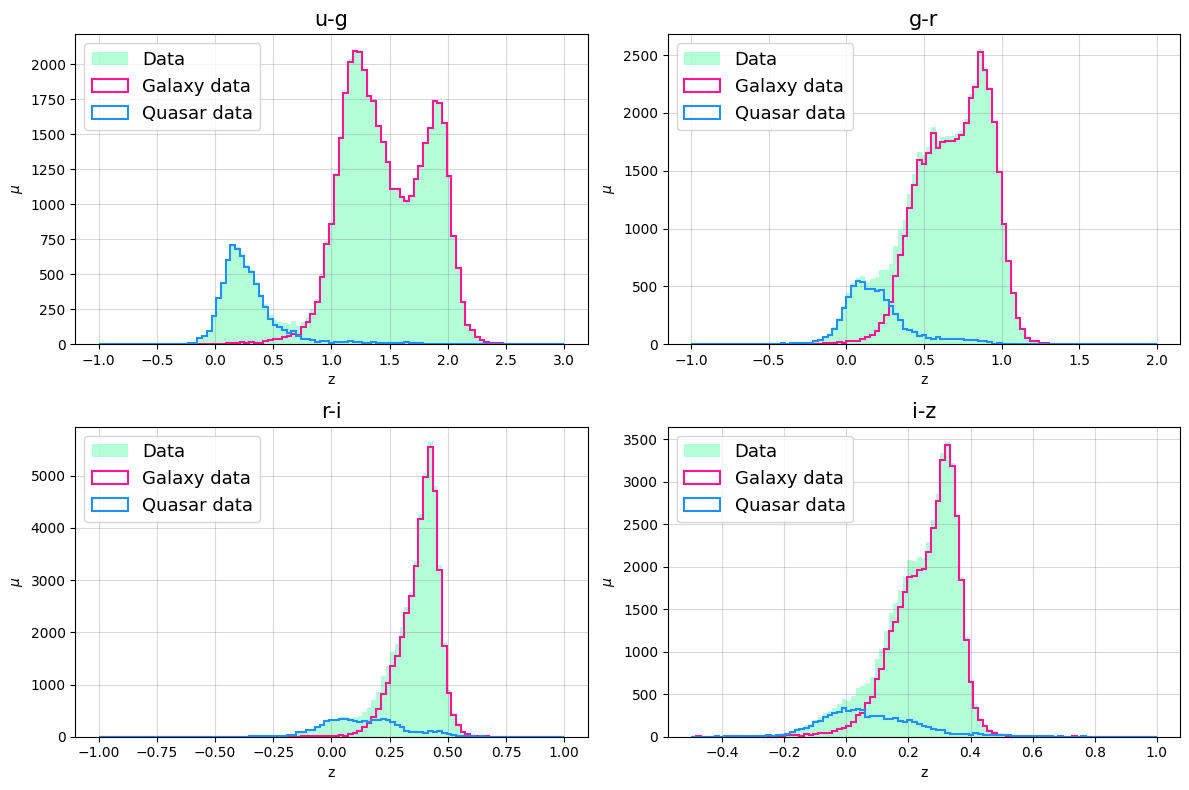

In [5]:
data_array = [u_g, g_r, r_i, i_z]
titles = ['u-g', 'g-r', 'r-i', 'i-z']
bins = [np.linspace(-1, 3, 100), np.linspace(-1, 2, 100), np.linspace(-1, 1, 100), np.linspace(-0.5, 1, 100)]

fig = plt.figure(figsize=(12, 8))
axes = []

for i, col in enumerate(data_array):
    ax = fig.add_subplot(2,2,1+i)
    axes.append(ax)
    plt.hist(col, bins = bins[i], color = 'springgreen', alpha = 0.3, label = 'Data')
    plt.hist(col[y==0], bins = bins[i], histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    plt.hist(col[y==1], bins = bins[i], histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    ax.grid(c='grey', alpha = 0.2)
    ax.set_xlabel('z')
    ax.set_ylabel('$\\mu$')
    ax.set_title(titles[i], fontsize = 15)
    ax.grid(alpha=0.3, c='gray')
    ax.legend(loc='upper left', fontsize = 13)

plt.tight_layout()
plt.show()

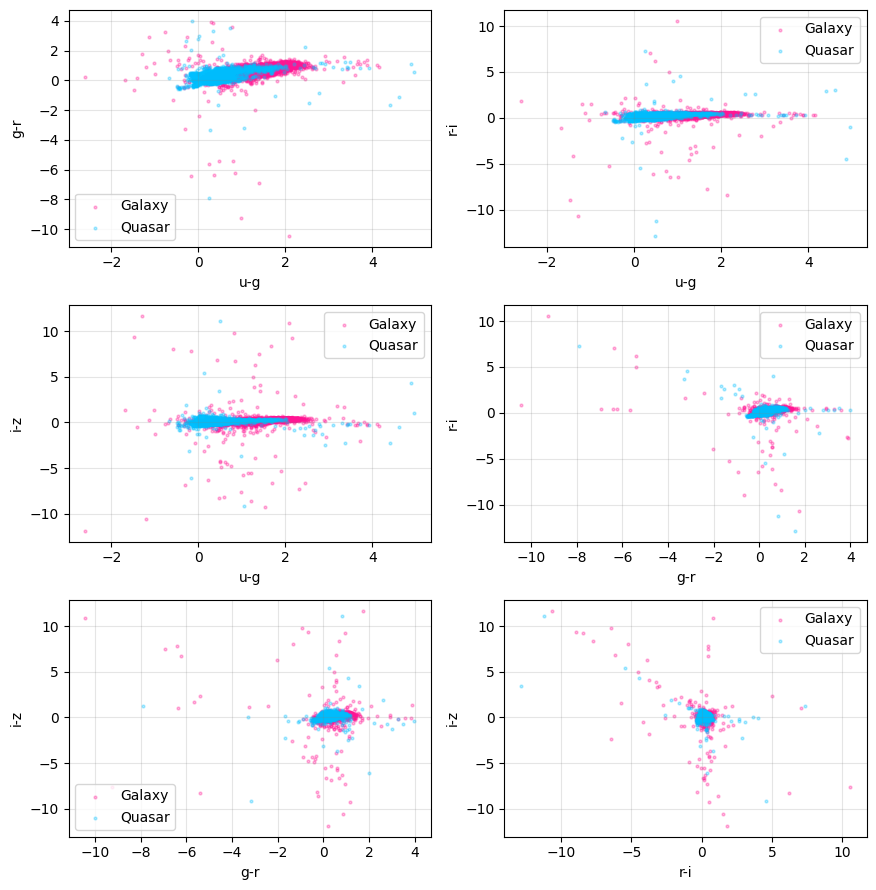

In [6]:
# I could've used corner for the next plots, but the contours were very small and I didn't get a clear idea of the data.

fig, axes = plt.subplots(3, 2, figsize = (9, 9))

axes[0, 0].scatter(u_g[y==0], g_r[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[0, 0].scatter(u_g[y==1], g_r[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[0, 0].grid(c='grey', alpha = 0.2)
axes[0, 0].set_xlabel('u-g')
axes[0, 0].set_ylabel('g-r')
axes[0, 0].legend()

axes[0, 1].scatter(u_g[y==0], r_i[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[0, 1].scatter(u_g[y==1], r_i[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[0, 1].grid(c='grey', alpha = 0.2)
axes[0, 1].set_xlabel('u-g')
axes[0, 1].set_ylabel('r-i')
axes[0, 1].legend()


axes[1, 0].scatter(u_g[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[1, 0].scatter(u_g[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[1, 0].grid(c='grey', alpha = 0.2)
axes[1, 0].set_xlabel('u-g')
axes[1, 0].set_ylabel('i-z')
axes[1, 0].legend()

axes[1, 1].scatter(g_r[y==0], r_i[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[1, 1].scatter(g_r[y==1], r_i[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[1, 1].grid(c='grey', alpha = 0.2)
axes[1, 1].set_xlabel('g-r')
axes[1, 1].set_ylabel('r-i')
axes[1, 1].legend()

axes[2, 0].scatter(g_r[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[2, 0].scatter(g_r[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[2, 0].grid(c='grey', alpha = 0.2)
axes[2, 0].set_xlabel('g-r')
axes[2, 0].set_ylabel('i-z')
axes[2, 0].legend()

axes[2, 1].scatter(r_i[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[2, 1].scatter(r_i[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[2, 1].grid(c='grey', alpha = 0.2)
axes[2, 1].set_xlabel('r-i')
axes[2, 1].set_ylabel('i-z')
axes[2, 1].legend()

plt.tight_layout()
plt.show()


### Scaling and train-test splitting


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=336)

# Data subset for hyperparameters tuning
X_train_sub = X_train[::10]     # N tot = 5000
X_test_sub = X_test[::10]
y_train_sub = y_train[::10]
y_test_sub = y_test[::10]

In [8]:
print(X_train_sub.shape)
print(X_test_sub.shape)

(3500, 4)
(1500, 4)



### Results to beat

In L19, the best classifier we could train was a random forest, with max_depth = $14$. Let's recap the results for the test dataset:

In [9]:
# For the random forest
rand_for = RandomForestClassifier(max_depth = 14, min_samples_split = 20, criterion = 'entropy', random_state = 336, n_jobs = -1) 
rand_for.fit(X_train, y_train)
y_prob_rand_for = rand_for.predict_proba(X_test)[:, 1]
y_train_pred_rf = rand_for.predict(X_train)
y_test_pred_rf = rand_for.predict(X_test)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rand_for)
roc_auc_rf = auc(fpr_rf, tpr_rf)

rf_results = []

rf_results.append(table_results(y_train, y_train_pred_rf))
rf_results.append(table_results(y_test, y_test_pred_rf))

In [10]:
clf_names = ['RF - train', 'RF - test']

rf_results_df = pd.DataFrame(rf_results, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
rf_results_df[['Accuracy', 'Contamination', 'Completeness']] = rf_results_df[['Accuracy', 'Contamination', 'Completeness']].round(4)
rf_results_df.insert(0, 'Classifier', clf_names)

In [11]:
display(Markdown('### Random forest results:'))
display(rf_results_df)

### Random forest results:

,Classifier,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,RF - train,0.9896,0.0238,0.9506,29881,116,247,4756
1,RF - test,0.9858,0.0367,0.9357,12793,76,137,1994



## Neural network - first approach

- Single hidden layer with 5 neurons
- Activation function: ReLU
- Learning rate: $0.001$


In [12]:
def trainnetwork(X_train, X_test, y_train, y_test, filename, n_epochs):

    if not os.path.isfile(filename):
    
        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=336)
        # Define neural network architecture
        model = keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(shape=np.shape(X_train[0])),
            # Inner layers, can add/change
            keras.layers.Dense(5,  activation='relu',kernel_initializer=my_init),
            # Output layer, do not change
            keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])
    
        model.compile(
            # Optimization algorithm, specify learning rate
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])
    
        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return float(lr * tf.math.exp(-0.05))
    
        # Actual Training
        history = model.fit(
            # Training inputs
            X_train,
            # Training outputs
            y_train,
            # Evaluate test set at each epoch
            validation_data=(X_test, y_test),
            # Batch size, default is 32
            #batch_size=32,
            # Number of epochs
            epochs=n_epochs,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs"+filename.split('.keras')[0], histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

    model = loadnetwork(filename)
    return model

#------------------------------------------------------------------------------------

def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model

In [13]:
trainnetwork(X_train, X_test, y_train, y_test, filename='Galaxy_quasar_NN_first.keras', n_epochs=50)

<Sequential name=sequential_1, built=True>

In [14]:
first_NN = loadnetwork('Galaxy_quasar_NN_first.keras')

In [15]:
y_train_pred_first = np.squeeze((first_NN.predict(X_train) > 0.5).astype("int32"))
y_test_pred_first = np.squeeze((first_NN.predict(X_test) > 0.5).astype("int32"))

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [16]:
first_attempt_results = []

first_attempt_results.append(table_results(y_train, y_train_pred_first))
first_attempt_results.append(table_results(y_test, y_test_pred_first))

In [17]:
# Plotting the ROC curves: first, what we need
y_probs_first = first_NN.predict(X_test)

fpr_first, tpr_first, _ = roc_curve(y_test, y_probs_first)
roc_auc_first = auc(fpr_first, tpr_first)

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


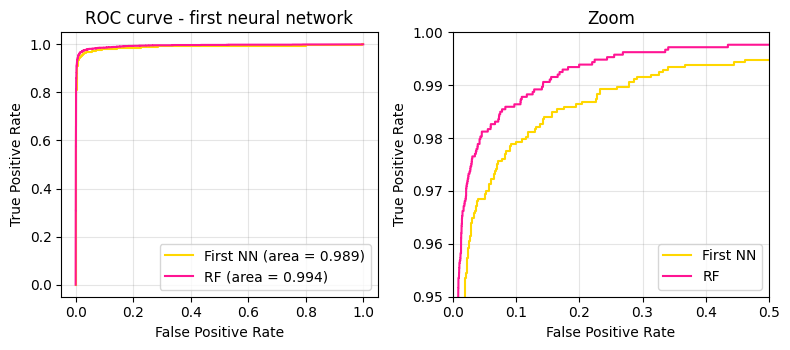

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3.6))

ax[0].plot(fpr_first, tpr_first, color='gold', lw=1.5, label='First NN (area = %0.3f)' % roc_auc_first)
ax[0].plot(fpr_rf, tpr_rf, color='deeppink', lw=1.5, label='RF (area = %0.3f)' % roc_auc_rf)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC curve - first neural network')
ax[0].legend(loc='lower right')
ax[0].grid(c='grey', alpha = 0.2)

ax[1].plot(fpr_first, tpr_first, color='gold', lw=1.5, label='First NN')
ax[1].plot(fpr_rf, tpr_rf, color='deeppink', lw=1.5, label='RF')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Zoom')
ax[1].legend(loc='lower right')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.95, 1)
ax[1].set_xlim(0, 0.5)

plt.tight_layout()
plt.show()

In [19]:
clf_names = ['First NN - train', 'First NN - test']

first_attempt_results_df = pd.DataFrame(first_attempt_results, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
first_attempt_results_df[['Accuracy', 'Contamination', 'Completeness']] = first_attempt_results_df[['Accuracy', 'Contamination', 'Completeness']].round(4)
first_attempt_results_df.insert(0, 'Classifier', clf_names)

In [20]:
display(Markdown('### Random forest results:'))
display(rf_results_df)

display(Markdown('### First neural network results:'))
display(first_attempt_results_df)

### Random forest results:

,Classifier,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,RF - train,0.9896,0.0238,0.9506,29881,116,247,4756
1,RF - test,0.9858,0.0367,0.9357,12793,76,137,1994


### First neural network results:

,Classifier,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,First NN - train,0.9839,0.0411,0.9268,29798,199,366,4637
1,First NN - test,0.9823,0.0458,0.9198,12775,94,171,1960


Our first attempt at a neural network yields good results, but the random forest is still better. Let's tune the neural network hyperparameters to make it better:

## Tuning the hyperparameters

In this section, we'll use the sub-datasets.

In [21]:
from tensorflow.keras import layers
import keras_tuner as kt

In [22]:
# Reference: https://keras.io/guides/keras_tuner/getting_started/

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(4,)))
    
    # Number of neurons in the first layer:
    neurons = hp.Int('neurons_first_layer', min_value=2, max_value=16, step=1)

    # Activation functions:
    activation_function = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    
    model.add(layers.Dense(units = neurons, activation = activation_function))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # Learning rate values:
    learning_rate = hp.Choice('learning rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    
    return model

In [23]:
tuner = kt.GridSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    directory='my_dir',
    project_name='hp_tuning',
)

Reloading Tuner from my_dir\hp_tuning\tuner0.json


In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
neurons_first_layer (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [25]:
tuner.search(X_train_sub, y_train_sub, epochs=50, validation_data=(X_test_sub, y_test_sub))

In [26]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_neurons = best_hyperparameters.get('neurons_first_layer')
best_learning_rate = best_hyperparameters.get('learning rate')
best_activation_function = best_hyperparameters.get('activation')
print('Best number of neurons: ' + str(best_neurons))
print('Best learning rate: ' + str(best_learning_rate))
print('Best activation function: ' + str(best_activation_function))

Best number of neurons: 11
Best learning rate: 0.1
Best activation function: sigmoid


In [27]:
def trainnetwork_tuned(X_train, X_test, y_train, y_test, filename, n_epochs):
        
    if not os.path.isfile(filename):
    
        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=336)
        # Define neural network architecture
        model = keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(shape=np.shape(X_train[0])),
            # Inner layers, can add/change
            keras.layers.Dense(11,  activation='sigmoid', kernel_initializer=my_init),
            # Output layer, do not change
            keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])
    
        model.compile(
            # Optimization algorithm, specify learning rate
            optimizer=keras.optimizers.Adam(learning_rate=0.1),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])
    
        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return float(lr * tf.math.exp(-0.05))
    
        # Actual Training
        history = model.fit(
            # Training inputs
            X_train,
            # Training outputs
            y_train,
            # Evaluate test set at each epoch
            validation_data=(X_test, y_test),
            # Batch size, default is 32
            #batch_size=32,
            # Number of epochs
            epochs=n_epochs,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs"+filename.split('.keras')[0], histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

    model = loadnetwork(filename)
    return model


In [28]:
trainnetwork_tuned(X_train, X_test, y_train, y_test, filename='Galaxy_quasar_NN_tuned.keras', n_epochs=50)

<Sequential name=sequential_1, built=True>

In [29]:
tuned_NN = loadnetwork('Galaxy_quasar_NN_tuned.keras')

In [30]:
y_train_pred_tuned = np.squeeze((tuned_NN.predict(X_train) > 0.5).astype("int32"))
y_test_pred_tuned = np.squeeze((tuned_NN.predict(X_test) > 0.5).astype("int32"))

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step


In [31]:
tuned_attempt_results = []

tuned_attempt_results.append(table_results(y_train, y_train_pred_tuned))
tuned_attempt_results.append(table_results(y_test, y_test_pred_tuned))

In [32]:
y_probs_tuned = tuned_NN.predict(X_test)

fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_probs_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step


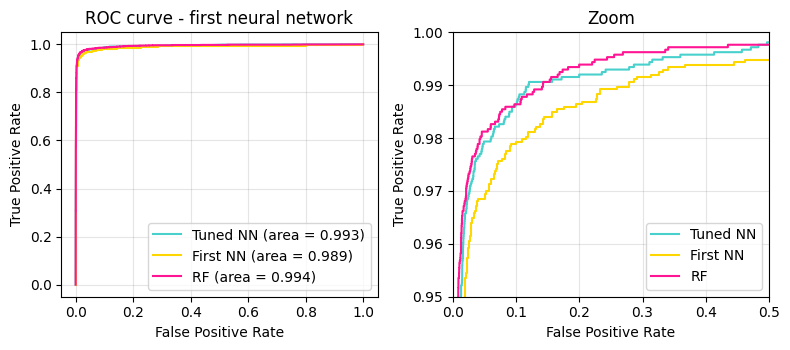

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3.6))

ax[0].plot(fpr_tuned, tpr_tuned, color='mediumturquoise', lw=1.5, label='Tuned NN (area = %0.3f)' % roc_auc_tuned)
ax[0].plot(fpr_first, tpr_first, color='gold', lw=1.5, label='First NN (area = %0.3f)' % roc_auc_first)
ax[0].plot(fpr_rf, tpr_rf, color='deeppink', lw=1.5, label='RF (area = %0.3f)' % roc_auc_rf)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC curve - first neural network')
ax[0].legend(loc='lower right')
ax[0].grid(c='grey', alpha = 0.2)

ax[1].plot(fpr_tuned, tpr_tuned, color='mediumturquoise', lw=1.5, label='Tuned NN')
ax[1].plot(fpr_first, tpr_first, color='gold', lw=1.5, label='First NN')
ax[1].plot(fpr_rf, tpr_rf, color='deeppink', lw=1.5, label='RF')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Zoom')
ax[1].legend(loc='lower right')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.95, 1)
ax[1].set_xlim(0, 0.5)

plt.tight_layout()
plt.show()

In [34]:
clf_names = ['Tuned NN - train', 'Tuned NN - test']

tuned_attempt_results_df = pd.DataFrame(tuned_attempt_results, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
tuned_attempt_results_df[['Accuracy', 'Contamination', 'Completeness']] = tuned_attempt_results_df[['Accuracy', 'Contamination', 'Completeness']].round(4)
tuned_attempt_results_df.insert(0, 'Classifier', clf_names)

In [35]:
display(Markdown('### Random forest results:'))
display(rf_results_df)

display(Markdown('### First neural network results:'))
display(first_attempt_results_df)

display(Markdown('### Tuned neural network results:'))
display(tuned_attempt_results_df)

### Random forest results:

,Classifier,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,RF - train,0.9896,0.0238,0.9506,29881,116,247,4756
1,RF - test,0.9858,0.0367,0.9357,12793,76,137,1994


### First neural network results:

,Classifier,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,First NN - train,0.9839,0.0411,0.9268,29798,199,366,4637
1,First NN - test,0.9823,0.0458,0.9198,12775,94,171,1960


### Tuned neural network results:

,Classifier,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,Tuned NN - train,0.9858,0.0410,0.9408,29796,201,296,4707
1,Tuned NN - test,0.9853,0.0409,0.9362,12784,85,136,1995


Almost there! Let's see if the classifier would perform better by adding another layer:

In [36]:
def build_model_2(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(4,)))
        
    # Add the first layer
    model.add(layers.Dense(units=11, activation='sigmoid'))
    
    # Decide whether to add a second Dense layer
    if hp.Boolean('add_second_layer'):
        second_layer_neurons = hp.Int('second_layer_units', min_value=2, max_value=16, step=1)
        second_layer_activation = hp.Choice('second_layer_activation', values=['relu', 'tanh', 'sigmoid'])
        model.add(layers.Dense(units=second_layer_neurons, activation=second_layer_activation))
    
    # Output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # Learning rate values:
    learning_rate = hp.Choice('learning rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
   
    return model

In [37]:
tuner2 = kt.GridSearch(
    hypermodel=build_model_2,
    objective='val_accuracy',
    directory='my_dir',
    project_name='hp_tuning_2',
)

Reloading Tuner from my_dir\hp_tuning_2\tuner0.json


In [38]:
tuner2.search_space_summary()

Search space summary
Default search space size: 4
add_second_layer (Boolean)
{'default': False, 'conditions': []}
learning rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}
second_layer_units (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 1, 'sampling': 'linear'}
second_layer_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}


In [39]:
tuner2.search(X_train_sub, y_train_sub, epochs=50, validation_data=(X_test_sub, y_test_sub))

In [40]:
best_hyperparameters_2 = tuner2.get_best_hyperparameters(num_trials=1)[0]
second_layer_yes_no = best_hyperparameters_2.get('add_second_layer')
best_neurons_2 = best_hyperparameters_2.get('second_layer_units')
best_learning_rate_2 = best_hyperparameters_2.get('learning rate')
best_activation_function_2 = best_hyperparameters_2.get('second_layer_activation')
print('Is a second layer needed? ' + str(second_layer_yes_no))
print('Best number of neurons: ' + str(best_neurons_2))
print('Best learning rate: ' + str(best_learning_rate_2))
print('Best activation function: ' + str(best_activation_function_2))

Is a second layer needed? True
Best number of neurons: 16
Best learning rate: 0.1
Best activation function: sigmoid


In [41]:
def trainnetwork_tuned_2(X_train, X_test, y_train, y_test, filename, n_epochs):

    if not os.path.isfile(filename):
    
        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=336)
        # Define neural network architecture
        model = keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(shape=np.shape(X_train[0])),
            # Inner layers, can add/change
            keras.layers.Dense(11,  activation='sigmoid', kernel_initializer=my_init),
            keras.layers.Dense(16, activation='sigmoid', kernel_initializer=my_init),
            # Output layer, do not change
            keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])
    
        model.compile(
            # Optimization algorithm, specify learning rate
            optimizer=keras.optimizers.Adam(learning_rate=0.1),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])
    
        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return float(lr * tf.math.exp(-0.05))
    
        # Actual Training
        history = model.fit(
            # Training inputs
            X_train,
            # Training outputs
            y_train,
            # Evaluate test set at each epoch
            validation_data=(X_test, y_test),
            # Batch size, default is 32
            #batch_size=32,
            # Number of epochs
            epochs=n_epochs,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs"+filename.split('.keras')[0], histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

    model = loadnetwork(filename)
    return model


In [42]:
trainnetwork_tuned_2(X_train, X_test, y_train, y_test, filename='Galaxy_quasar_NN_tuned_2.keras', n_epochs=50)

<Sequential name=sequential_1, built=True>

In [43]:
tuned_NN_2 = loadnetwork('Galaxy_quasar_NN_tuned_2.keras')

In [44]:
y_train_pred_tuned_2 = np.squeeze((tuned_NN_2.predict(X_train) > 0.5).astype("int32"))
y_test_pred_tuned_2 = np.squeeze((tuned_NN_2.predict(X_test) > 0.5).astype("int32"))

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step


In [45]:
tuned_2_attempt_results = []

tuned_2_attempt_results.append(table_results(y_train, y_train_pred_tuned_2))
tuned_2_attempt_results.append(table_results(y_test, y_test_pred_tuned_2))

In [46]:
y_probs_tuned_2 = tuned_NN_2.predict(X_test)

fpr_tuned_2, tpr_tuned_2, _ = roc_curve(y_test, y_probs_tuned_2)
roc_auc_tuned_2 = auc(fpr_tuned_2, tpr_tuned_2)

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


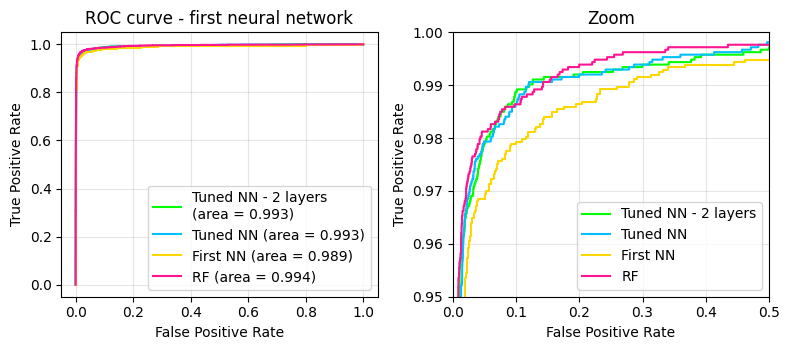

In [47]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3.6))

ax[0].plot(fpr_tuned_2, tpr_tuned_2, color='lime', lw=1.5, label='Tuned NN - 2 layers\n(area = %0.3f)' % roc_auc_tuned_2)
ax[0].plot(fpr_tuned, tpr_tuned, color='deepskyblue', lw=1.5, label='Tuned NN (area = %0.3f)' % roc_auc_tuned)
ax[0].plot(fpr_first, tpr_first, color='gold', lw=1.5, label='First NN (area = %0.3f)' % roc_auc_first)
ax[0].plot(fpr_rf, tpr_rf, color='deeppink', lw=1.5, label='RF (area = %0.3f)' % roc_auc_rf)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC curve - first neural network')
ax[0].legend(loc='lower right')
ax[0].grid(c='grey', alpha = 0.2)

ax[1].plot(fpr_tuned_2, tpr_tuned_2, color='lime', lw=1.5, label='Tuned NN - 2 layers')
ax[1].plot(fpr_tuned, tpr_tuned, color='deepskyblue', lw=1.5, label='Tuned NN')
ax[1].plot(fpr_first, tpr_first, color='gold', lw=1.5, label='First NN')
ax[1].plot(fpr_rf, tpr_rf, color='deeppink', lw=1.5, label='RF')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Zoom')
ax[1].legend(loc='lower right')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.95, 1)
ax[1].set_xlim(0, 0.5)

plt.tight_layout()
plt.show()

In [48]:
clf_names = ['Tuned NN 2 layers - train', 'Tuned NN 2 layers - test']

tuned_2_attempt_results_df = pd.DataFrame(tuned_2_attempt_results, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
tuned_2_attempt_results_df[['Accuracy', 'Contamination', 'Completeness']] = tuned_2_attempt_results_df[['Accuracy', 'Contamination', 'Completeness']].round(4)
tuned_2_attempt_results_df.insert(0, 'Classifier', clf_names)

In [49]:
display(Markdown('### Random forest results:'))
display(rf_results_df)

display(Markdown('### First neural network results:'))
display(first_attempt_results_df)

display(Markdown('### Tuned neural network results:'))
display(tuned_attempt_results_df)

display(Markdown('### Tuned neural network (2 layers) results:'))
display(tuned_2_attempt_results_df)

### Random forest results:

,Classifier,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,RF - train,0.9896,0.0238,0.9506,29881,116,247,4756
1,RF - test,0.9858,0.0367,0.9357,12793,76,137,1994


### First neural network results:

,Classifier,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,First NN - train,0.9839,0.0411,0.9268,29798,199,366,4637
1,First NN - test,0.9823,0.0458,0.9198,12775,94,171,1960


### Tuned neural network results:

,Classifier,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,Tuned NN - train,0.9858,0.0410,0.9408,29796,201,296,4707
1,Tuned NN - test,0.9853,0.0409,0.9362,12784,85,136,1995


### Tuned neural network (2 layers) results:

,Classifier,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,Tuned NN 2 layers - train,0.9867,0.0339,0.9396,29832,165,302,4701
1,Tuned NN 2 layers - test,0.9851,0.0382,0.9324,12790,79,144,1987


So, even if for the data subset a second layer was preferrable, for the whole dataset the performance is slightly worse. Still, there's no evident sign of overfitting, so that's good!

Let's see the results for the best neural network:

In [55]:
def plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, color):

    # Plots the histograms for the classified data of a given color (u-g, g-r, r-i, i-z)
    # Plots:
    # - The predicted labels for the train dataset;
    # - The true labels for the train dataset;
    # - The predicted labels for the test dataset;
    # - The true labels for the test dataset.
    
    # Defining color
    if (color == 'u-g'): ind = 0
    elif (color == 'g-r'): ind = 1
    elif (color == 'r-i'): ind = 2
    elif (color == 'i-z'): ind = 3

    bins_vec = [np.linspace(-3, 3, 100), np.linspace(-1, 2, 100), np.linspace(-1, 1, 100), np.linspace(-0.5, 1, 100)]
    bins = bins_vec[ind]
    
    fig, axes = plt.subplots(2, 2, figsize = (10, 7))
    
    axes[0, 0].hist(X_train[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Train data')
    axes[0, 0].hist(X_train[y_train_pred==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[0, 0].hist(X_train[y_train_pred==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[0, 0].grid(c='grey', alpha = 0.2)
    axes[0, 0].set_xlabel(color)
    axes[0, 0].set_title('Predicted labels for train dataset')
    axes[0, 0].legend()
    
    axes[0, 1].hist(X_train[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Train data')
    axes[0, 1].hist(X_train[y_train==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[0, 1].hist(X_train[y_train==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[0, 1].grid(c='grey', alpha = 0.2)
    axes[0, 1].set_xlabel(color)
    axes[0, 1].set_title('True labels for train dataset')
    axes[0, 1].legend()

    axes[1, 0].hist(X_test[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Test data')
    axes[1, 0].hist(X_test[y_test_pred==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[1, 0].hist(X_test[y_test_pred==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[1, 0].grid(c='grey', alpha = 0.2)
    axes[1, 0].set_xlabel(color)
    axes[1, 0].set_title('Predicted labels for test dataset')
    axes[1, 0].legend()
    
    axes[1, 1].hist(X_test[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Test data')
    axes[1, 1].hist(X_test[y_test==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[1, 1].hist(X_test[y_test==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[1, 1].grid(c='grey', alpha = 0.2)
    axes[1, 1].set_xlabel(color)
    axes[1, 1].set_title('True labels for test dataset')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

#---------------------------------------------------------------------------------------------------------------------------------------------------

def mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, color1, color2):

    # Plots, in a color1 vs color2 plane, the mislabeled points for the train and test data.
    
    # Defining color1
    if (color1 == 'u-g'): ind1 = 0
    elif (color1 == 'g-r'): ind1 = 1
    elif (color1 == 'r-i'): ind1 = 2
    elif (color1 == 'i-z'): ind1 = 3

    # Defining color2
    if (color2 == 'u-g'): ind2 = 0
    elif (color2 == 'g-r'): ind2 = 1
    elif (color2 == 'r-i'): ind2 = 2
    elif (color2 == 'i-z'): ind2 = 3
    
    # "False quasar" = fq: galaxies mislabeled as quasars
    # "False galaxy" = fg: quasars mislabeled as galaxies
    
    mislabels_train = np.where(y_train != y_train_pred)[0]
    fq_train_indexes = mislabels_train[(y_train[mislabels_train] == 0) & (y_train_pred[mislabels_train] == 1)]
    fg_train_indexes = mislabels_train[(y_train[mislabels_train] == 1) & (y_train_pred[mislabels_train] == 0)]
    fq_train = X_train[fq_train_indexes]
    fg_train = X_train[fg_train_indexes]

    mislabels_test = np.where(y_test != y_test_pred)[0]
    fq_test_indexes = mislabels_test[(y_test[mislabels_test] == 0) & (y_test_pred[mislabels_test] == 1)]
    fg_test_indexes = mislabels_test[(y_test[mislabels_test] == 1) & (y_test_pred[mislabels_test] == 0)]
    fq_test = X_test[fq_test_indexes]
    fg_test = X_test[fg_test_indexes]

    
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
    
    ax[0].scatter(X_train[:, ind1], X_train[:, ind2], s = 4, c = 'grey', alpha = 0.3, label = 'Data')
    ax[0].scatter(fq_train[:, ind1], fq_train[:, ind2], s = 4, c = 'gold', alpha = 0.7, label = '"False quasars"')
    ax[0].scatter(fg_train[:, ind1], fg_train[:, ind2], s = 4, c = 'magenta', alpha = 0.7, label = '"False galaxies"')
    ax[0].grid(c='grey', alpha = 0.2)
    ax[0].set_title('Mislabeled train datapoints')
    ax[0].set_xlabel(color1)
    ax[0].set_ylabel(color2)
    ax[0].legend()
    
    ax[1].scatter(X_test[:, ind1], X_test[:, ind2], s = 4, c = 'grey', alpha = 0.3, label = 'Data')
    ax[1].scatter(fq_test[:, ind1], fq_test[:, ind2], s = 4, c = 'gold', alpha = 0.7, label = '"False quasars"')
    ax[1].scatter(fg_test[:, ind1], fg_test[:, ind2], s = 4, c = 'magenta', alpha = 0.7, label = '"False galaxies"')
    ax[1].grid(c='grey', alpha = 0.2)
    ax[1].set_title('Mislabeled test datapoints')
    ax[1].set_xlabel(color1)
    ax[1].set_ylabel(color2)
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

## Results for random forest:

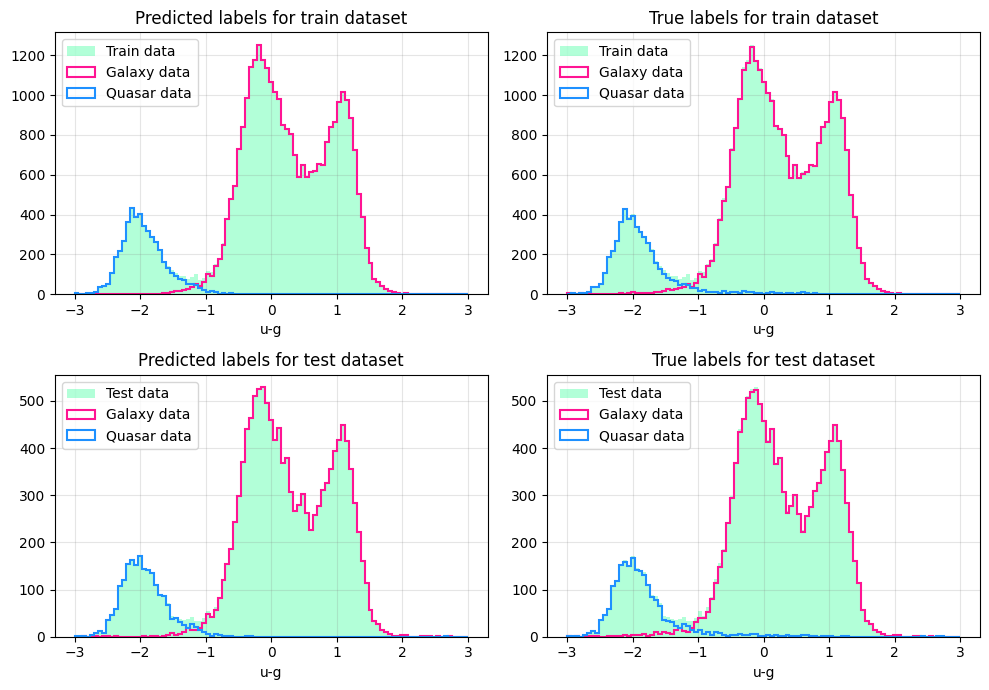

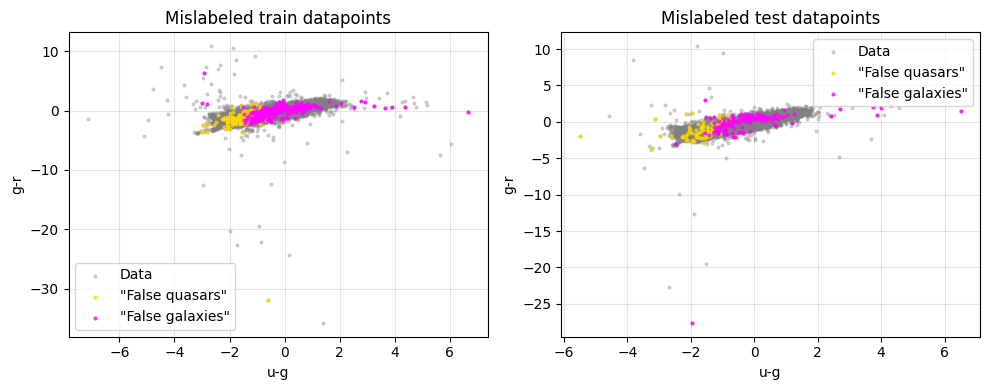

## Results for neural network:

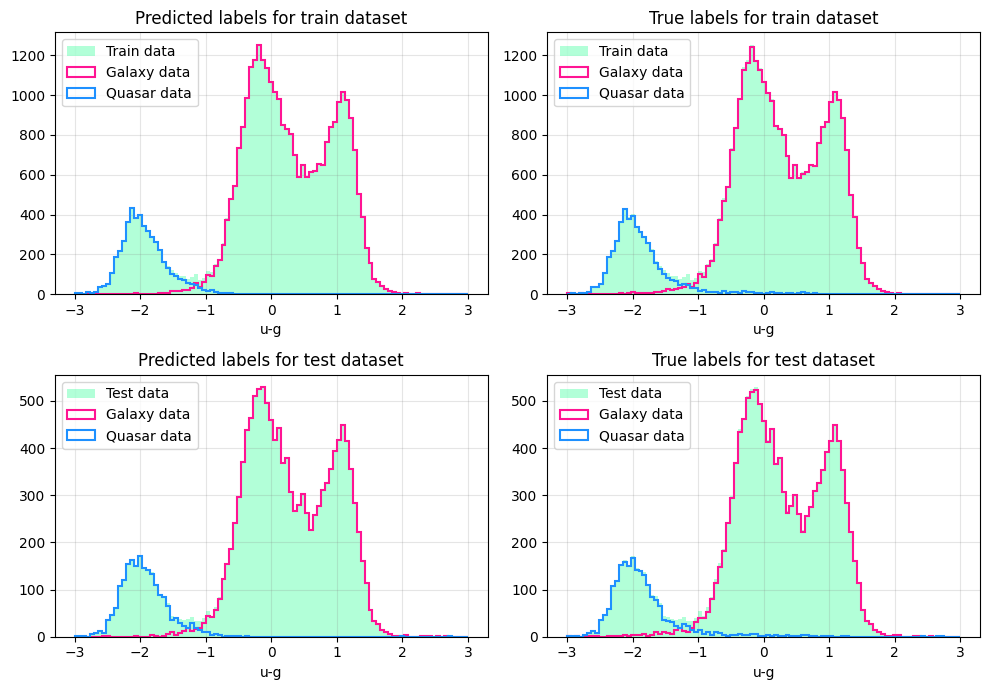

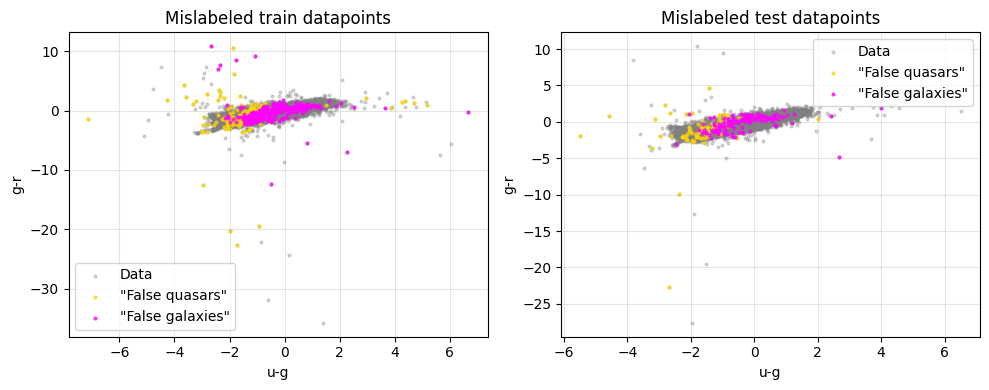

In [57]:
display(Markdown('## Results for random forest:'))

plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_rf, y_test_pred_rf, 'u-g')
mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_rf, y_test_pred_rf, 'u-g', 'g-r')

display(Markdown('## Results for neural network:'))

plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_tuned, y_test_pred_tuned, 'u-g')
mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_tuned, y_test_pred_tuned, 'u-g', 'g-r')